In [ ]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent / 'sarfusion'))
sys.path.append(str(Path.cwd().parent / 'sarfusion' / 'data'))

In [201]:
from torchvision import transforms
from pathlib import PosixPath
from tqdm import tqdm
from einops import rearrange
import numpy as np
import os
import torch
import cv2
import lovely_tensors as lt
import torch.nn.functional as F
import torchvision.transforms.functional as tvF

from ultralytics.utils import IterableSimpleNamespace
from ultralytics.data.utils import check_det_dataset

from sarfusion.data.wisard import WiSARDYOLODataset
from sarfusion.data.wisard import collate_rgb_ir

lt.monkey_patch()

In [13]:
def draw_bbox_yolo(image, bboxes, color=(0, 255, 0), thickness=2):
    """
    Draw bounding boxes on an image given bounding box coordinates in YOLO format.
    
    Args:
    - image: numpy array representing the image
    - bboxes: list of bounding box coordinates in YOLO format (center_x, center_y, width, height)
    - color: color of the bounding box (BGR format)
    - thickness: thickness of the bounding box lines
    
    Returns:
    - image with bounding boxes drawn
    """
    image = rearrange(image, 'c h w  -> h w c')
    color = torch.tensor(color, device=image.device).float() / 255
    
    height, width = image.shape[:2]
    for bbox in bboxes:
        cls, center_x, center_y, w, h = bbox
        left = int(center_x * width - w * width / 2)
        top = int(center_y * height - h * height / 2)
        right = int(center_x * width + w * width / 2)
        bottom = int(center_y * height + h * height / 2)
        
        # Drawing bounding box
        image[top:bottom, left:left+thickness] = color
        image[top:bottom, right-thickness:right] = color
        image[top:top+thickness, left:right] = color
        image[bottom-thickness:bottom, left:right] = color
        
    image = rearrange(image, 'h w c -> c h w')
    
    return image

In [289]:
hyp = IterableSimpleNamespace(
    task="detect",
    mode="train",
    model=None,
    data="wisards_vis_ir.yaml",
    epochs=500,
    time=None,
    patience=20,
    batch=16,
    imgsz=1024,
    save=True,
    save_period=5,
    val_period=1,
    cache=False,
    device=None,
    workers=0,
    project="",
    name="",
    exist_ok=False,
    pretrained=True,
    optimizer="AdamW",
    verbose=True,
    seed=0,
    deterministic=True,
    single_cls=True,
    rect=False,
    cos_lr=False,
    close_mosaic=10,
    resume=False,
    amp=True,
    fraction=1.0,
    profile=False,
    freeze="None",
    multi_scale=False,
    overlap_mask=True,
    mask_ratio=4,
    dropout=0.0,
    val=True,
    split="val",
    save_json=False,
    save_hybrid=False,
    conf=None,
    iou=0.7,
    max_det=300,
    half=False,
    dnn=False,
    plots=True,
    source=None,
    vid_stride=1,
    stream_buffer=False,
    visualize=False,
    augment=False,
    agnostic_nms=False,
    classes=None,
    retina_masks=False,
    embed=None,
    show=True,
    save_frames=False,
    save_txt=False,
    save_conf=False,
    save_crop=False,
    show_labels=True,
    show_conf=True,
    show_boxes=True,
    line_width=None,
    format="torchscript",
    keras=False,
    optimize=False,
    int8=False,
    dynamic=False,
    simplify=False,
    opset=None,
    workspace=4,
    nms=False,
    lr0=1e-05,
    lrf=1e-05,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3.0,
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,
    box=7.5,
    cls=0.5,
    dfl=1.5,
    pose=12.0,
    kobj=1.0,
    label_smoothing=0.0,
    nbs=64,
    hsv_h=0.0,
    hsv_s=0.0,
    hsv_v=0.0,
    degrees=0.0,
    translate=0.1,
    scale=0.5,
    shear=0.0,
    perspective=0.0,
    flipud=0.0,
    fliplr=0.5,
    bgr=0.0,
    mosaic=0.0,
    mixup=0.0,
    copy_paste=0.0,
    auto_augment="randaugment",
    erasing=0.4,
    crop_fraction=1.0,
    cfg=None,
    tracker="botsort.yaml",
    augment_vis_ir=True,
    save_dir="SarYOLO/VIS_ALL_IR_SYNC11",
)

In [290]:
data = check_det_dataset(hyp.data)
data

{'path': Path('/home/pasquale/projects/RGBT-Fusion-for-SAR/dataset/WiSARD'),
 'train': '/home/pasquale/projects/RGBT-Fusion-for-SAR/dataset/WiSARD/train_vis_ir.txt',
 'val': '/home/pasquale/projects/RGBT-Fusion-for-SAR/dataset/WiSARD/val_vis_ir.txt',
 'test': '/home/pasquale/projects/RGBT-Fusion-for-SAR/dataset/WiSARD/test_vis_ir.txt',
 'names': {0: 'stands', 1: 'rests', 2: 'not_defined'},
 'yaml_file': 'wisards_vis_ir.yaml',
 'nc': 3}

In [378]:
img_path = data['test']

wisard = WiSARDYOLODataset(
        img_path=img_path,
        imgsz=1024,
        batch_size=1,
        augment=False,  # augmentation
        hyp=hyp,  # TODO: probably add a get_hyps_from_cfg function
        rect=False,  # rectangular batches
        cache=False,
        single_cls=False,
        stride=64,
        pad=0.5,
        prefix='\x1b[34m\x1b[1mtrain: \x1b[0m',
        task="detect",
        classes=None,
        data=data,
        fraction=1.0,
        augment_vis_ir=False,
    )

train: Scanning dataset/WiSARD/210417_MtErie_Enterprise_VIS_0003/labels.cache... 708 images, 19 backgrounds, 0 corrupt: 100%|██████████| 708/708 [00:00<?, ?it/s]

In [379]:
len(wisard)

708

In [380]:
first_ks = [0]

for k in tqdm(range(1, len(wisard))):
    im_file, _ = wisard.im_files[k]
    path = os.path.dirname(im_file)
    last_k = first_ks[-1]
    last_path = os.path.dirname(wisard.im_files[last_k][0])
    if path != last_path:
        print(f"Actual k: {k}, last k: {last_k}, Paths: \n{path} \n{last_path} \n")
        first_ks.append(k)
    

100%|██████████| 707/707 [00:00<00:00, 49969.21it/s]

Actual k: 264, last k: 0, Paths: 
dataset/WiSARD/210417_MtErie_Enterprise_VIS_0005/images 
dataset/WiSARD/210417_MtErie_Enterprise_VIS_0003/images 

Actual k: 536, last k: 264, Paths: 
dataset/WiSARD/210417_MtErie_Enterprise_VIS_0007/images 
dataset/WiSARD/210417_MtErie_Enterprise_VIS_0005/images 



In [381]:
i = 1000

In [382]:
i = 0

In [383]:
first_ks

[0, 264, 536]

In [384]:
wisard[i]

IndexError: list index out of range

In [356]:
fig1 = wisard[i]['img'][:3].rgb().fig
fig2 = (wisard[i]['img'][3:] / 255).chans().fig

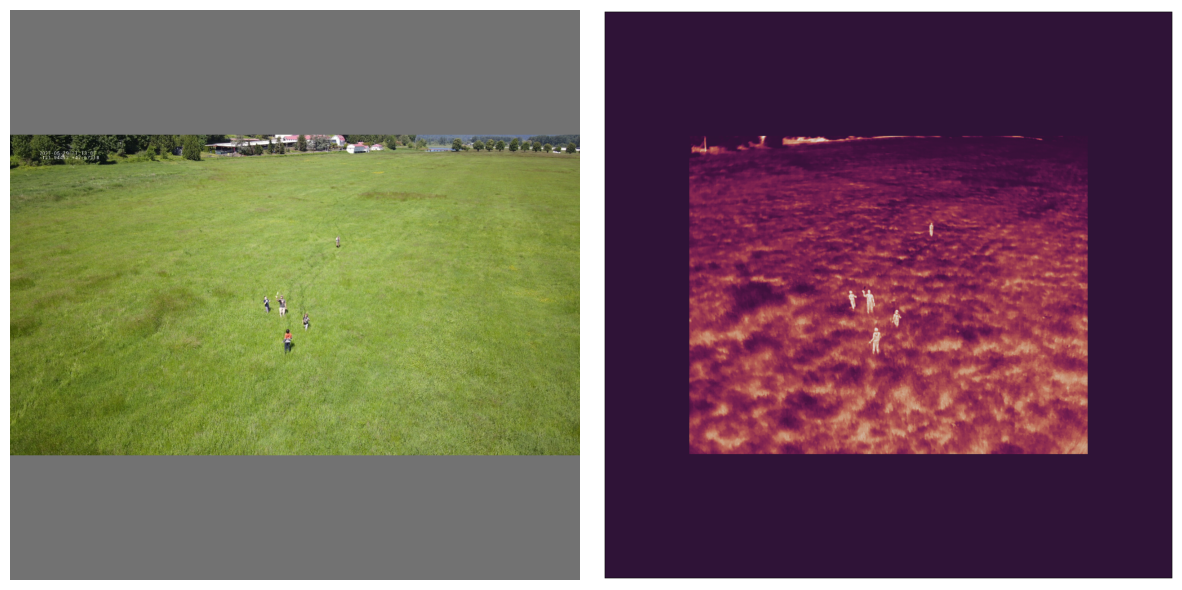

In [357]:
import matplotlib.pyplot as plt

# Assume fig1 and fig2 are your existing figures containing images

# Create a new figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Get the images from the existing figures and display them in the new axes
for ax in fig1.get_axes():
    for im in ax.get_images():
        ax1.imshow(im.get_array(), cmap=im.get_cmap(), norm=im.norm)

for ax in fig2.get_axes():
    for im in ax.get_images():
        ax2.imshow(im.get_array(), cmap=im.get_cmap(), norm=im.norm)

# Optionally, remove axis ticks and labels
ax1.axis('off')
ax2.axis('off')

# Display the combined plot
plt.tight_layout()
plt.show()


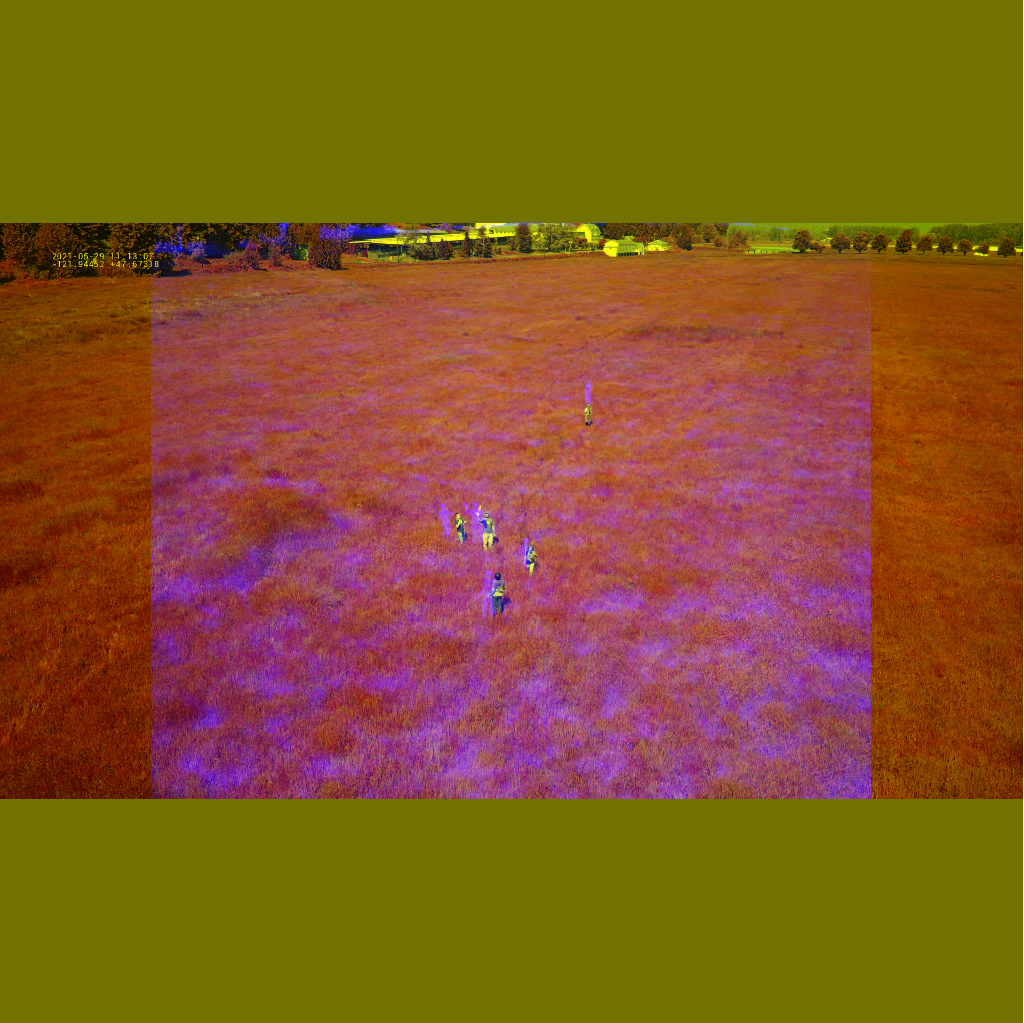

In [358]:
wisard[i]['img'][1:].rgb()

In [359]:
def transpose_aspect_ratio(size_orig, size_new=None, aspect_ratio_new=None):
    """
    Transpose the aspect ratio of an image from one size to another, maintaining the same width.
    
    Args:
    - size_orig: tuple representing the original size of the image
    - size_new: tuple representing the new size of the image
    
    Returns:
    - tuple representing the new size of the image with the same aspect ratio as the original image
    """
    height_orig, width_orig = size_orig
    if size_new is None and aspect_ratio_new is None:
        raise ValueError("Either size_new or aspect_ratio_new must be provided.")
    elif size_new is not None and aspect_ratio_new is not None:
        raise ValueError("Only one of size_new or aspect_ratio_new must be provided.")
    elif size_new is not None:
        height_new, width_new = size_new
        aspect_ratio_new = width_new / height_new
    
    new_height = int(width_orig / aspect_ratio_new)
        
    return (new_height, width_orig)

In [360]:
rgb_path, ir_path = wisard.im_files[i]
im_vis = torch.tensor(cv2.imread(rgb_path)).permute(2, 0, 1)  # BGR
im_ir = torch.tensor(cv2.imread(ir_path)).permute(2, 0, 1)  # IR

In [361]:
im_vis

tensor[3, 1080, 1920] u8 n=6220800 (5.9Mb) x∈[0, 255] μ=114.157 σ=42.933

In [362]:
im_ir

tensor[3, 512, 640] u8 n=983040 (0.9Mb) x∈[0, 252] μ=85.873 σ=39.155

In [375]:
new_shape = transpose_aspect_ratio(im_ir.shape[1:], 
                                #    size_new=im_vis.shape[1:],
                                   aspect_ratio_new=1.1
                                   )
print("Stretched shape:", new_shape)
new_im_ir = F.interpolate(im_ir.unsqueeze(0), size=new_shape, mode='bilinear', align_corners=False).squeeze(0)

Stretched shape: (581, 640)


In [376]:
ir = new_im_ir[0:1]  # All channels are the same
# calculate h, w displacement
rgb_h, rgb_w = im_vis.shape[1:]
ir_h, ir_w = ir.shape[1:]

new_ir_h = rgb_h
new_ir_w = int(ir_w * (rgb_h / ir_h))
print("New IR shape:", (new_ir_h, new_ir_w))

new_ir = tvF.resize(ir, (new_ir_h, new_ir_w))
w_pad = (rgb_w - new_ir_w) // 2
new_ir = tvF.pad(new_ir, (w_pad, 0, w_pad, 0))
im = torch.cat((im_vis, new_ir), dim=0)
print("Final shape:", im.shape)

New IR shape: (1080, 1189)


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 1920 but got size 1919 for tensor number 1 in the list.

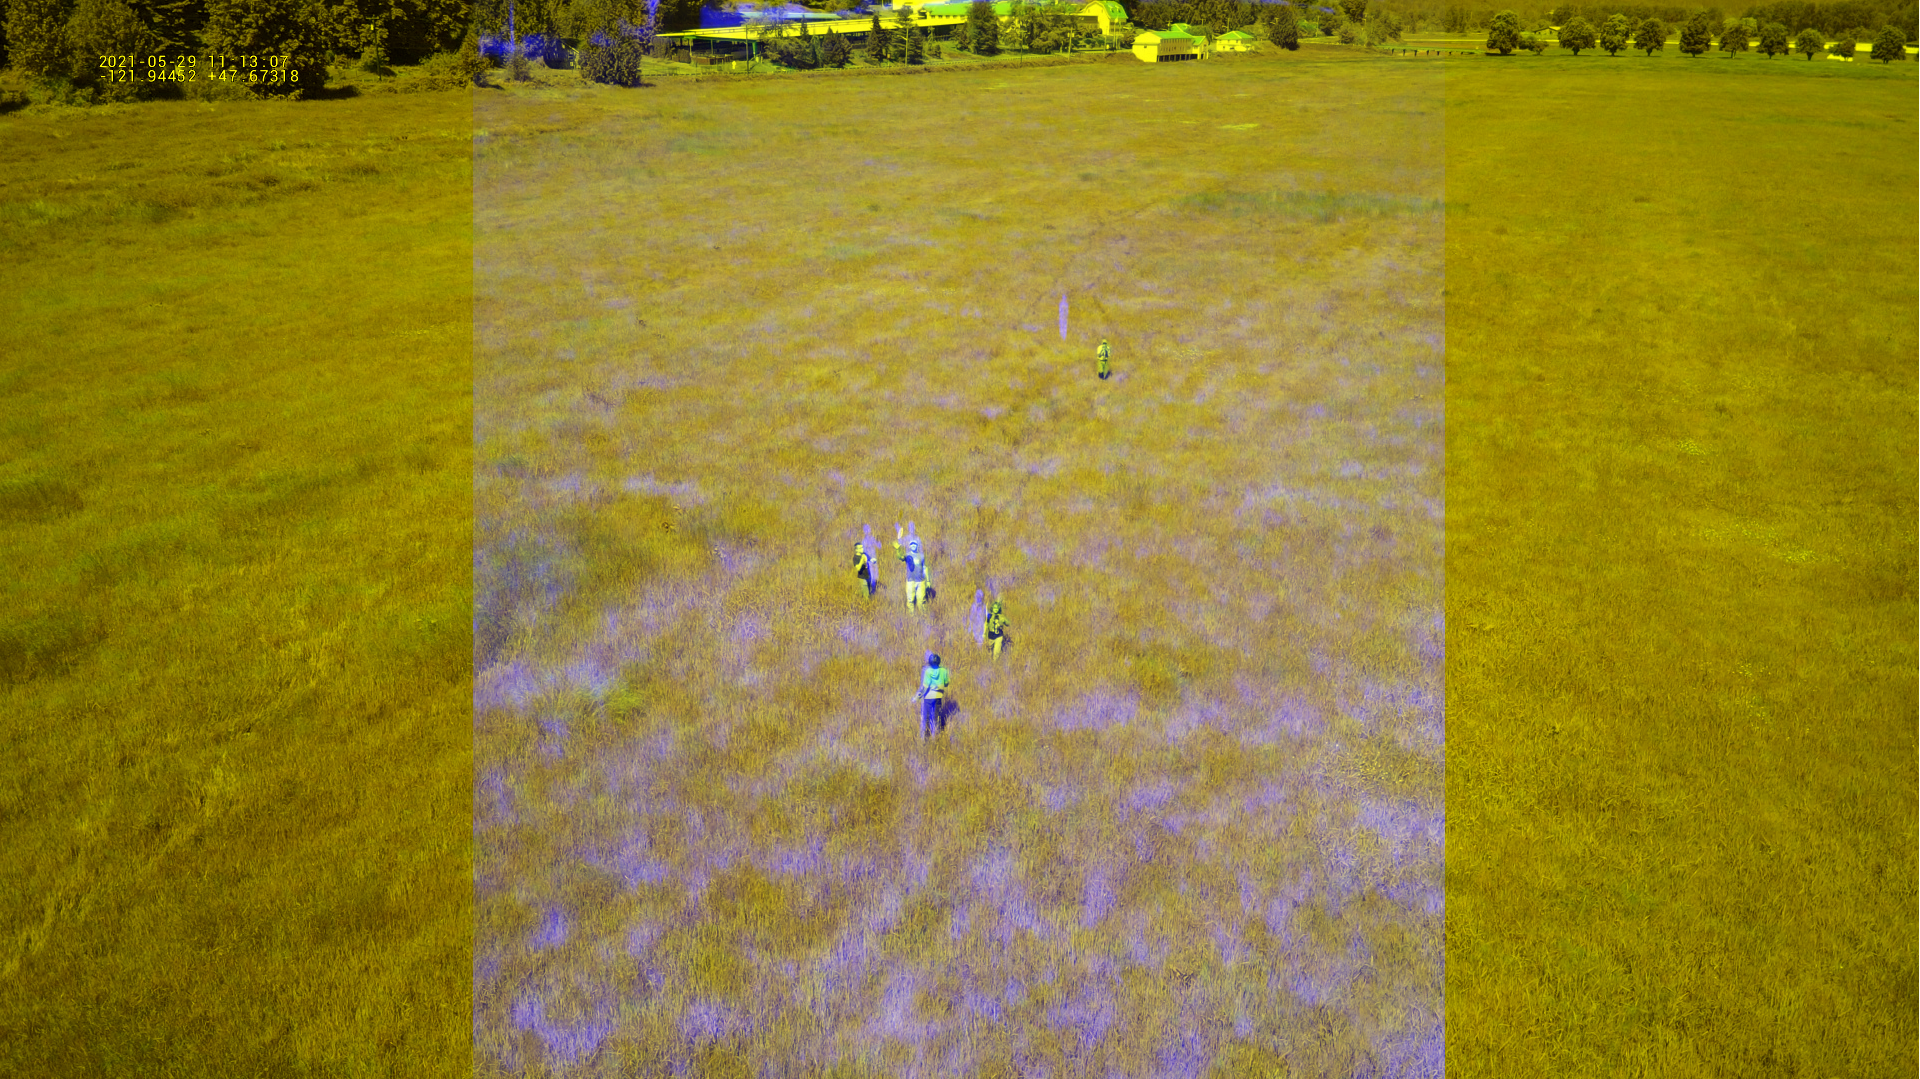

In [377]:
im[1:].rgb()